In [1]:
# Importing necessary libraries

import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Set it to your desired number of threads
import missingno as msno
import shap

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

from IPython.display import display #To display dataframe with a nice format.

# Setting display precision for pandas
pd.set_option("display.precision", 2)
# Set display option to show all columns
pd.set_option('display.max_columns', None)

blue_green      = (82/255, 162/255, 160/255)
blue_green_dark = (41/255, 81/255, 81/255)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# ==================================================================================================
# Set the fontsize & Bold for each GRAPH !!!
# ==================================================================================================
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 10
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams['axes.titlepad'] = 20 

In [2]:
import mlflow
from mlflow.tracking import MlflowClient
from pprint import pprint

mlflow.end_run()

client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

all_experiments = client.search_experiments()
print(all_experiments)

default_experiment = [
    {"name": experiment.name, "lifecycle_stage": experiment.lifecycle_stage}
    for experiment in all_experiments
    if experiment.name == "Default"
][0]

pprint(default_experiment)

[<Experiment: artifact_location='mlflow-artifacts:/648886531450483040', creation_time=1715717540248, experiment_id='648886531450483040', last_update_time=1715717540248, lifecycle_stage='active', name='FREELANCER_Models_GREHOUNDS_RACE_BINARY_FORECASTING', tags={'mlflow.note.content': 'FREELANCER PROJECT',
 'project_name': 'Binary Greyhound forecasting (0 or 1) (Loosers or Winners)'}>, <Experiment: artifact_location='mlflow-artifacts:/435037538350658571', creation_time=1714568500251, experiment_id='435037538350658571', last_update_time=1714568500251, lifecycle_stage='active', name='P7_Models', tags={'mlflow.note.content': 'This is the supervised binary classifying of the bank '
                        'loan default/non default using XGBoost Model.',
 'project_name': 'Binary Loan forecasting (0 or 1)'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1714473625166, experiment_id='0', last_update_time=1714473625166, lifecycle_stage='active', name='Default', tags={}>]
{

In [3]:
# ==================================================================================================
# READ DATA
# ==================================================================================================
import csv

# Directory containing the CSV files
folder_path = r"C:\Users\Olivi\OneDrive\Documents\OC_Formation_DATA_SCIENCE\PROJET7_Implementez_un_modele_de_scoring\DATA"

# List of CSV files to read
csv_files = [
    "application_test.csv",
    "application_train.csv",
    # "bureau.csv",
    # "bureau_balance.csv",
    # "credit_card_balance.csv",
    # "HomeCredit_columns_description.csv",
    # "installments_payments.csv",
    # "POS_CASH_balance.csv",
    # "previous_application.csv",
    # "sample_submission.csv"
]



# Dictionary to store loaded DataFrames
dfs = {}

# Read each CSV file and store it in the dictionary
for file in csv_files:
    print(file)
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    dfs[file.replace('.csv', '')] = df

print("Datasets loaded successfully! :D")

df_application_test = dfs['application_test']
df_application_train = dfs['application_train']
# df_bureau = dfs['bureau']
# df_bureau_balance = dfs['bureau_balance']
# df_credit_card_balance = dfs['credit_card_balance']
# df_HomeCredit_columns_description = dfs['HomeCredit_columns_description']
# df_installments_payments = dfs['installments_payments']
# df_POS_CASH_balance = dfs['POS_CASH_balance']
# df_previous_application = dfs['previous_application']
# df_sample_submission = dfs['sample_submission']

df_application_train_copy =  df_application_train

application_test.csv
application_train.csv
Datasets loaded successfully! :D


In [4]:
df_application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,4.07e+05,24700.5,3.51e+05,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1.88e-02,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,1.43e-02,0.00,0.07,0.08,0.12,0.04,0.02,1.90e-02,0.00e+00,0.00e+00,0.03,0.04,0.97,0.63,1.44e-02,0.00,0.07,0.08,0.12,3.77e-02,0.02,1.98e-02,0.0,0.00,0.03,0.04,0.97,0.62,1.44e-02,0.00,0.07,0.08,0.12,0.04,0.02,1.93e-02,0.00e+00,0.00,reg oper account,block of flats,1.49e-02,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1.29e+06,35698.5,1.13e+06,Family,State servant,Higher education,Married,House / apartment,3.54e-03,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,6.05e-02,0.08,0.03,0.29,0.33,0.01,0.08,5.49e-02,3.90e-03,9.80e-03,0.09,0.05,0.99,0.80,4.97e-02,0.08,0.03,0.29,0.33,1.28e-02,0.08,5.54e-02,0.0,0.00,0.10,0.05,0.99,0.80,6.08e-02,0.08,0.03,0.29,0.33,0.01,0.08,5.58e-02,3.90e-03,0.01,reg oper account,block of flats,7.14e-02,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,1.35e+05,6750.0,1.35e+05,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1.00e-02,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0

In [5]:
df_application_train.shape

(307511, 122)

# I. EDA

TARGET
0    282686
1     24825
Name: count, dtype: int64

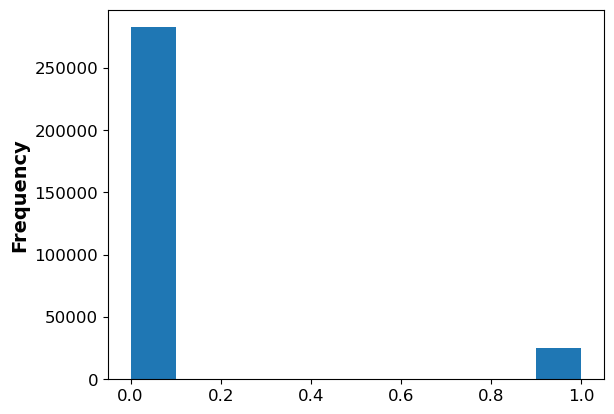

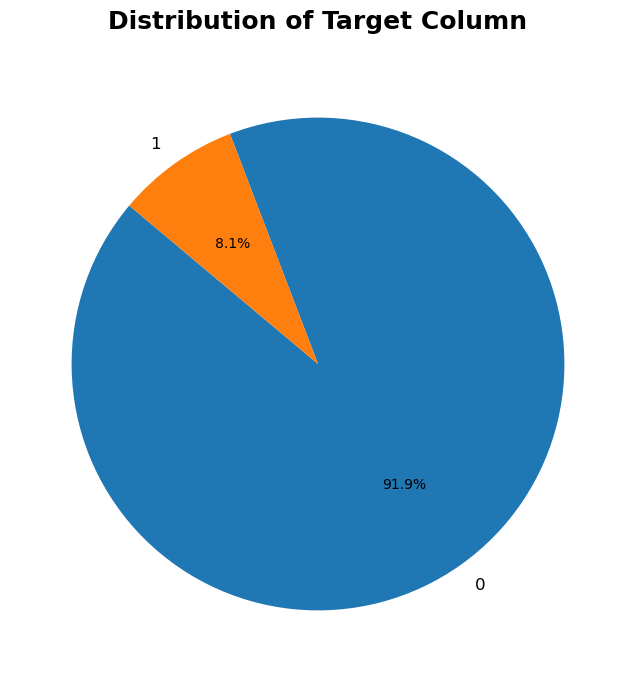

In [6]:
# ==================================================================================================
# Examine the Distribution of the Target Column
# ==================================================================================================
display(df_application_train['TARGET'].value_counts())
df_application_train['TARGET'].astype(int).plot.hist();

# Count the values in the target column
target_counts = df_application_train['TARGET'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Column')
plt.show()

In [7]:
# ==================================================================================================
# MISSING VALUES
# ==================================================================================================

def missing_values_table(df, threshold=50):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Remove columns with missing values exceeding the threshold
    columns_to_remove = mis_val_table_ren_columns[
        mis_val_table_ren_columns['% of Total Values'] > threshold].index
    df_cleaned = df.drop(columns=columns_to_remove)
    
    print("\nColumns with missing values exceeding {}% have been removed:".format(threshold))
    print(columns_to_remove)
    
    # Return the cleaned dataframe
    return df_cleaned, mis_val_table_ren_columns

# Apply the function to remove columns with missing values exceeding 50%
df_application_train, mis_val_table_ren_columns = missing_values_table(df_application_train, threshold=47)
df_application_train, mis_val_table_ren_columns = missing_values_table(df_application_train, threshold=47)
display(mis_val_table_ren_columns.head(20))
display(df_application_train.shape)

# Apply the function to remove columns with missing values exceeding 50%
df_application_test, mis_val_table_ren_columns = missing_values_table(df_application_test, threshold=47)
df_application_test, mis_val_table_ren_columns = missing_values_table(df_application_test, threshold=47)
display(mis_val_table_ren_columns.head(20))
display(df_application_test.shape)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.

Columns with missing values exceeding 47% have been removed:
Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI',
       'FLOORSMIN_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_AVG', 'LANDAREA_MEDI',
       'LANDAREA_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG',
       'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MEDI',
       'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'ELEVATORS_MEDI',
       'ELEVATORS_MODE', 'ELEVATORS_AVG', 'WALLSMATERIAL_MODE',
       'APARTMENTS_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG',
       'ENTRANCES_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'LIVINGAREA_MEDI',
 

,Missing Values,% of Total Values
OCCUPATION_TYPE,96391,31.3
EXT_SOURCE_3,60965,19.8
AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.5
AMT_REQ_CREDIT_BUREAU_QRT,41519,13.5
AMT_REQ_CREDIT_BUREAU_MON,41519,13.5
AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.5
AMT_REQ_CREDIT_BUREAU_DAY,41519,13.5
AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.5
NAME_TYPE_SUITE,1292,0.4
DEF_60_CNT_SOCIAL_CIRCLE,1021,0.3


(307511, 73)

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.

Columns with missing values exceeding 47% have been removed:
Index(['COMMONAREA_MODE', 'COMMONAREA_MEDI', 'COMMONAREA_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MODE', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE',
       'FLOORSMIN_AVG', 'OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI',
       'YEARS_BUILD_MODE', 'LANDAREA_MODE', 'LANDAREA_AVG', 'LANDAREA_MEDI',
       'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MODE',
       'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG',
       'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'ELEVATORS_AVG',
       'WALLSMATERIAL_MODE', 'APARTMENTS_MODE', 'APARTMENTS_MEDI',
       'APARTMENTS_AVG', 'HOUSETYPE_MODE', 'ENTRANCES_MODE', 'ENTRANCES_MEDI',
       'ENTRANCES_AVG', 'LIVINGAREA_AVG', 

,Missing Values,% of Total Values
YEARS_BEGINEXPLUATATION_AVG,22856,46.9
YEARS_BEGINEXPLUATATION_MODE,22856,46.9
YEARS_BEGINEXPLUATATION_MEDI,22856,46.9
TOTALAREA_MODE,22624,46.4
EMERGENCYSTATE_MODE,22209,45.6
EXT_SOURCE_1,20532,42.1
OCCUPATION_TYPE,15605,32.0
EXT_SOURCE_3,8668,17.8
AMT_REQ_CREDIT_BUREAU_HOUR,6049,12.4
AMT_REQ_CREDIT_BUREAU_QRT,6049,12.4


(48744, 78)

In [8]:
# ==================================================================================================
# HANDLING MISSING VALUES
# CATEGORICAL
# ==================================================================================================

# INPUTE categorical feature with a fix value (ex : for OCCUPATION_TYPE, we inpute "UNKNOWN OCCUPATION TYPE"
df_application_train['OCCUPATION_TYPE'].fillna('UNKNOWN OCCUPATION_TYPE', inplace=True)
df_application_train['NAME_TYPE_SUITE'].fillna('UNKNOWN NAME_TYPE_SUITE', inplace=True)
df_application_test['OCCUPATION_TYPE'].fillna('UNKNOWN OCCUPATION_TYPE', inplace=True)
df_application_test['NAME_TYPE_SUITE'].fillna('UNKNOWN NAME_TYPE_SUITE', inplace=True)


In [9]:
# ==================================================================================================
# HANDLING MISSING VALUES
# NUMERICAL
# ==================================================================================================

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select the numerical features for imputation
numerical_features = [
    'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE',
    'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'
]

# Create an IterativeImputer
imputer = IterativeImputer(random_state=42)

# Impute missing values in the numerical features
df_application_train[numerical_features] = imputer.fit_transform(df_application_train[numerical_features])
df_application_test[numerical_features] = imputer.fit_transform(df_application_test[numerical_features])


In [10]:
# ==================================================================================================
# VERIFICATION MISSING VALUES
# ==================================================================================================
# Apply the function to remove columns with missing values exceeding 50%
df_application_train, mis_val_table_ren_columns = missing_values_table(df_application_train, threshold=47)
display(mis_val_table_ren_columns.head(20))
display(df_application_train.shape)

Your selected dataframe has 73 columns.
There are 0 columns that have missing values.

Columns with missing values exceeding 47% have been removed:
Index([], dtype='object')


,Missing Values,% of Total Values


(307511, 73)

In [11]:
# ==================================================================================================
# CATEGORICAL FEATURES ENCODING
# ==================================================================================================
# Number of unique classes in each object column
df_application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               19
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

In [12]:
# ==================================================================================================
# CATEGORICAL FEATURES - ENCODING
# LABEL ENCODING (NB category <= 2)
# ONE HOT ENCODING (NB category > 2)
#
# In this notebook, we will use Label Encoding for any categorical variables with only 2 categories 
# and One-Hot Encoding for any categorical variables with more than 2 categories.
# ==================================================================================================

# === I. LABEL ENCODER ===
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_application_train:
    if df_application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_application_train[col])
            # Transform both training and testing data
            df_application_train[col] = le.transform(df_application_train[col])
            df_application_test[col] = le.transform(df_application_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

# === II. ONE HOT ENCODER ===
# one-hot encoding of categorical variables
df_application_train = pd.get_dummies(df_application_train)
df_application_test = pd.get_dummies(df_application_test)

print('Training Features shape: ', df_application_train.shape)
print('Testing Features shape: ', df_application_test.shape)

3 columns were label encoded.
Training Features shape:  (307511, 184)
Testing Features shape:  (48744, 187)


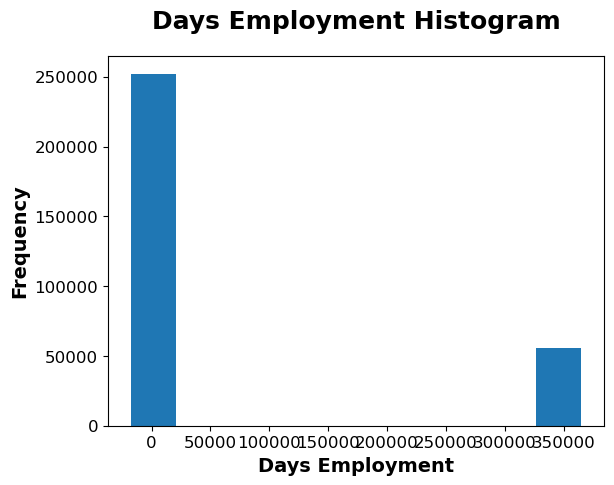

In [13]:
# ==================================================================================================
# DATA ANOMALIES
# ==================================================================================================
df_application_train['DAYS_EMPLOYED'].describe()
df_application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [14]:
anom = df_application_train[df_application_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_application_train[df_application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


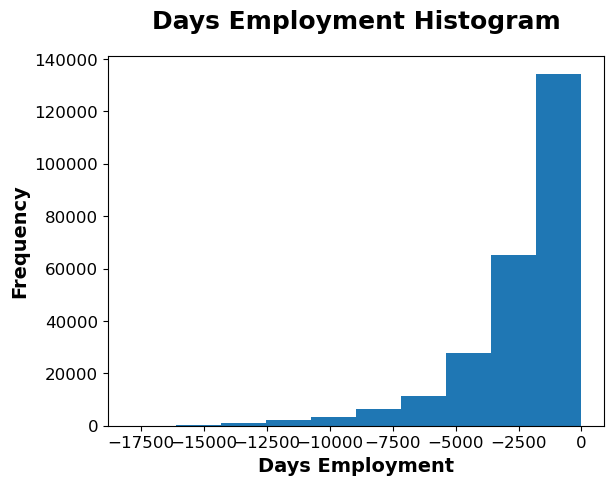

In [15]:
# Create an anomalous flag column
df_application_train['DAYS_EMPLOYED_ANOM'] = df_application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [16]:
df_application_test['DAYS_EMPLOYED_ANOM'] = df_application_test["DAYS_EMPLOYED"] == 365243
df_application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (df_application_test["DAYS_EMPLOYED_ANOM"].sum(), len(df_application_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [17]:
# ==================================================================================================
# CORRELATIONS
# .00-.19 “very weak”
# .20-.39 “weak”
# .40-.59 “moderate”
# .60-.79 “strong”
# .80-1.0 “very strong”
# ==================================================================================================
# Find correlations with the target and sort
correlations = df_application_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.04
FLAG_DOCUMENT_3                                      0.04
REG_CITY_NOT_LIVE_CITY                               0.04
FLAG_EMP_PHONE                                       0.05
NAME_EDUCATION_TYPE_Secondary / secondary special    0.05
REG_CITY_NOT_WORK_CITY                               0.05
DAYS_ID_PUBLISH                                      0.05
CODE_GENDER_M                                        0.05
DAYS_LAST_PHONE_CHANGE                               0.06
NAME_INCOME_TYPE_Working                             0.06
REGION_RATING_CLIENT                                 0.06
REGION_RATING_CLIENT_W_CITY                          0.06
DAYS_EMPLOYED                                        0.07
DAYS_BIRTH                                           0.08
TARGET                                               1.00
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                              

-0.07823930830982712

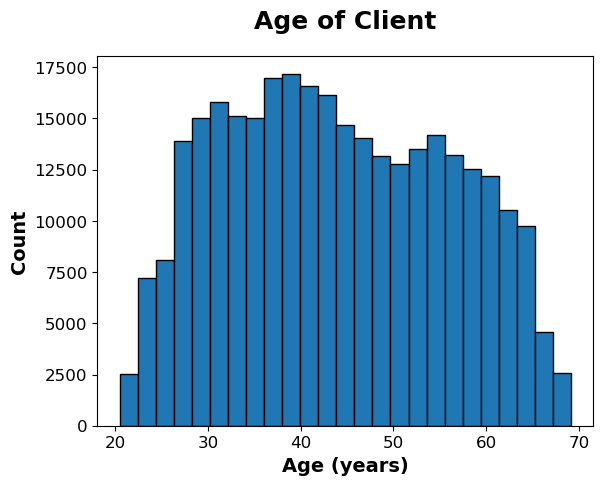

In [18]:
# Find the correlation of the positive days since birth and target
df_application_train['DAYS_BIRTH'] = abs(df_application_train['DAYS_BIRTH'])
display(df_application_train['DAYS_BIRTH'].corr(df_application_train['TARGET']))

# Plot the distribution of ages in years
plt.hist(df_application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

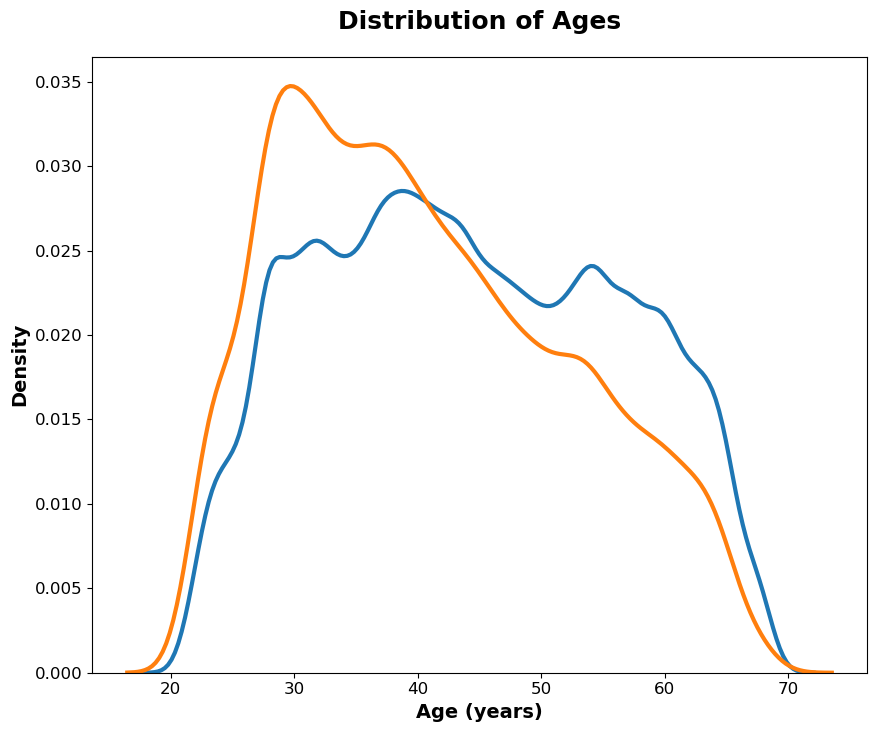

In [19]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.12,8532.80,23.38
"(25.0, 30.0]",0.11,10155.22,27.82
"(30.0, 35.0]",0.10,11854.85,32.48
"(35.0, 40.0]",0.09,13707.91,37.56
"(40.0, 45.0]",0.08,15497.66,42.46
"(45.0, 50.0]",0.07,17323.90,47.46
"(50.0, 55.0]",0.07,19196.49,52.59
"(55.0, 60.0]",0.06,20984.26,57.49
"(60.0, 65.0]",0.05,22780.55,62.41


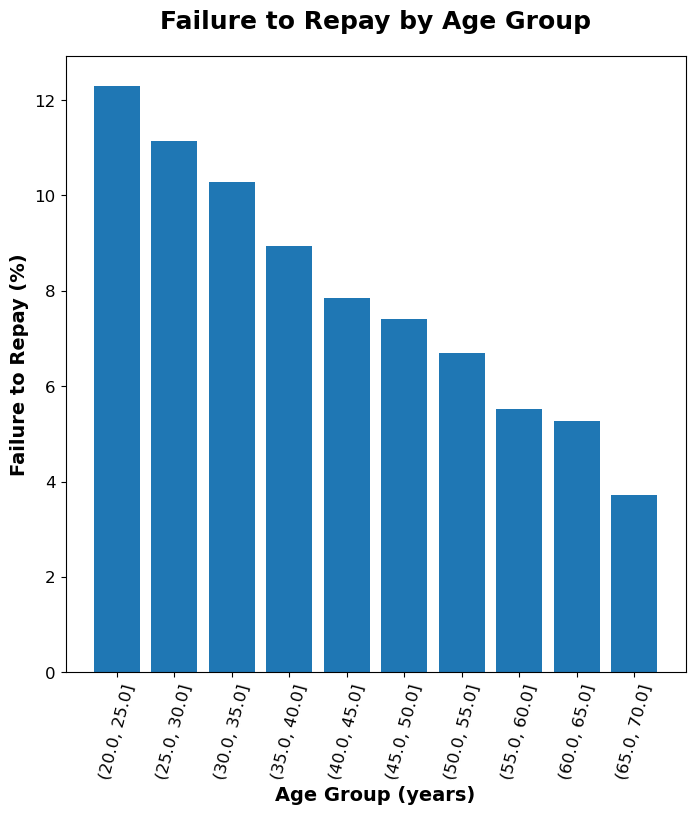

In [20]:
# Age information into a separate dataframe
age_data = df_application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
display(age_groups)

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

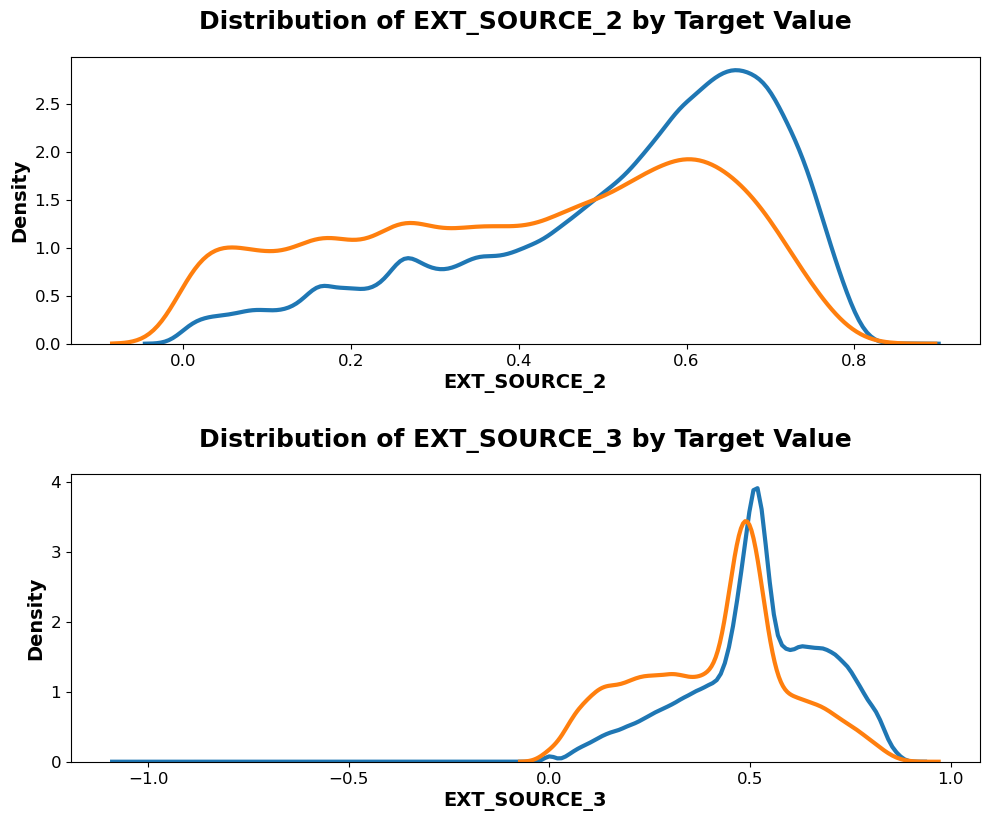

In [21]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

# II. DATA PREPROCESSING

In [22]:
# ==================================================================================================
# DATA PREPROCESSING
# ==================================================================================================
# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Model Selection
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [23]:
# # ==================================================================================================
# # DATA PREPROCESSING
# # ==================================================================================================
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split


def preprocess_dataframe(df):
  """
  Preprocesses the input DataFrame (df) for machine learning tasks.

  Args:
      df (pandas.DataFrame): The DataFrame to preprocess.

  Returns:
      tuple: A tuple containing the following elements:
          - X_train (pandas.DataFrame): The preprocessed training features.
          - y_train (pandas.Series): The training target variable.
          - X_test (pandas.DataFrame): The preprocessed testing features.
          - y_test (pandas.Series): The testing target variable.
  """

  # Check for missing values in numerical and categorical features separately
  numerical_missing = df.select_dtypes(include=['int64', 'float64']).isnull().sum().any()
  categorical_missing = df.select_dtypes(include=['object']).isnull().sum().any()

  # Define imputation strategies based on missing value presence
  numerical_imputer = SimpleImputer(strategy='median')
  categorical_imputer = SimpleImputer(strategy='most_frequent')

  # Create preprocessing pipelines for numerical and categorical features
  numerical_transformer = Pipeline(steps=[
      ('imputer', numerical_imputer),
      ('scaler', StandardScaler())
  ])

  categorical_transformer = Pipeline(steps=[
      ('imputer', categorical_imputer),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  # Combine transformers into a single ColumnTransformer
  preprocessor = ColumnTransformer(transformers=[
      ('numerical', numerical_transformer, df.select_dtypes(include=['int64', 'float64']).columns),
      ('categorical', categorical_transformer, df.select_dtypes(include=['object']).columns)
  ])

  # Apply preprocessing to the DataFrame
  df_transformed = preprocessor.fit_transform(df)

  # Convert the NumPy array back to a DataFrame with column names (without prefixes)
  new_feature_names = []
  for name in preprocessor.get_feature_names_out():
    new_feature_names.append(name.split('__')[1])  # Remove prefix using split and indexing

    
  # Convert the NumPy array back to a DataFrame with column names
  df_transformed = pd.DataFrame(df_transformed, columns=new_feature_names)
  df_transformed.drop('TARGET', axis=1, inplace=True)

  # Replace feature name with space
    
  # Split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(df_transformed, df['TARGET'], test_size=0.2, random_state=42)

  return X_train, y_train, X_test, y_test, df_transformed


In [24]:
# ==================================================================================================
# DATA PROCESSING
# ==================================================================================================
df_application_train = df_application_train_copy
X_train, y_train, X_test, y_test, df_transformed= preprocess_dataframe(df_application_train)
display(df_transformed)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity

In [25]:
# # # ==================================================================================================
# # # DATA PREPROCESSING
# # # ==================================================================================================
# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
# from sklearn.model_selection import train_test_split


# def preprocess_dataframe(df):
#     # Define features and target variable
#     X = df.drop(columns=['TARGET'])
#     y = df['TARGET']

#     # Convert boolean features to integer
#     bool_cols = X.select_dtypes(include=['bool']).columns
#     X[bool_cols] = X[bool_cols].astype(int)

#     # Split data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Preprocessing for numerical features
#     numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
#     numerical_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='median')),
#         ('scaler', StandardScaler())])

#     # Preprocessing for categorical features
#     categorical_features = X.select_dtypes(include=['object']).columns
#     categorical_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('onehot', OneHotEncoder(handle_unknown='ignore'))])


#     # Combine preprocessing steps
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numerical_transformer, numerical_features),
#             ('cat', categorical_transformer, categorical_features)])

#     return preprocessor, X_train, y_train, X_test, y_test



# III. TARGET PREDICTION AND RESULTS SAVED USING MLFLOW

In [26]:
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities.experiment import Experiment

# Set tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Initialize the MLflow client
client = MlflowClient()

# Provide an Experiment description that will appear in the UI
experiment_description = (
    "FREELANCER PROJECT (https://www.fr.freelancer.com/projects/python/Python-Data-Science-Modelling-Expert/details)"
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "Binary Greyhound forecasting (0 or 1) (Loosers or Winners)",
    "mlflow.note.content": experiment_description,
}

# Check if the experiment already exists
experiment_name = "FREELANCER_Models_GREHOUNDS_RACE_BINARY_FORECASTING"
existing_experiment = client.get_experiment_by_name(experiment_name)

if existing_experiment:
    print(f"Experiment '{experiment_name}' already exists. Using existing experiment.")
    experiment_id = existing_experiment.experiment_id
else:
    # Create the Experiment, providing a unique name
    experiment_id = client.create_experiment(
        name=experiment_name, tags=experiment_tags
    )


Experiment 'FREELANCER_Models_GREHOUNDS_RACE_BINARY_FORECASTING' already exists. Using existing experiment.


In [27]:
from IPython.display import display

shap.initjs()


In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
import random
from shap import Explainer
import matplotlib



def log_shap_values_and_features(shap_values, feature_names):
    with mlflow.start_run() as run:
        # Log SHAP values
        shap_values_path = "shap_values.npy"
        np.save(shap_values_path, shap_values.values)
        mlflow.log_artifact(shap_values_path)
        
        # Log feature names
        feature_names_path = "feature_names.txt"
        with open(feature_names_path, "w") as f:
            for feature in feature_names:
                f.write(f"{feature}\n")
        mlflow.log_artifact(feature_names_path)



'''
Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) 
et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)

Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le 
meilleur modèle et ses meilleurs hyperparamètres. Attention cette minimisation du coût métier doit passer par l’optimisation du seuil 
qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)
'''
def calculate_business_metric(y_true, y_pred_proba, cost_fn, cost_fp, threshold):
    """
    Calculate the total business cost based on the predictions and true labels, considering the imbalance in the cost of false negatives (FN) and false positives (FP).

    Parameters:
    - y_true (array-like): True binary labels. Each element indicates whether the corresponding sample belongs to the positive class (1) or the negative class (0).
    - y_pred_proba (array-like): Predicted probabilities for the positive class.
    - cost_fn (float): Cost associated with each false negative (FN). This represents the financial loss incurred when a negative instance is incorrectly classified as positive.
    - cost_fp (float): Cost associated with each false positive (FP). This represents the financial loss incurred when a positive instance is incorrectly classified as negative.
    - threshold (float): Threshold for classification. Probabilities above this threshold are classified as positive, while those below are classified as negative.

    Returns:
    - total_cost (float): Total cost calculated based on the business metric. The total cost is computed as the sum of the costs of false negatives (FN) and false positives (FP).

    Example:
    Consider the following scenario:
    - True labels (y_true): [1, 0, 1, 0, 0]
    - Predicted probabilities for the positive class (y_pred_proba): [0.8, 0.3, 0.4, 0.9, 0.2]
    - Cost of false negatives (cost_fn): $10
    - Cost of false positives (cost_fp): $1
    - Classification threshold (threshold): 0.5

    Using these inputs, let's calculate the total business cost:
    - For the first sample, the true label is 1 (positive), and the predicted probability is 0.8, which is above the threshold. Hence, it's correctly classified as positive.
    - For the second sample, the true label is 0 (negative), but the predicted probability is 0.3, which is below the threshold. Hence, it's correctly classified as negative.
    - For the third sample, the true label is 1 (positive), and the predicted probability is 0.4, which is below the threshold. Hence, it's incorrectly classified as positive (false positive).
    - For the fourth sample, the true label is 0 (negative), and the predicted probability is 0.9, which is above the threshold. Hence, it's incorrectly classified as positive (false negative).
    - For the fifth sample, the true label is 0 (negative), but the predicted probability is 0.2, which is below the threshold. Hence, it's incorrectly classified as positive.

    Based on these classifications and costs, the total business cost is calculated as follows:
    - Cost of false negatives: 1 * $100 = $100
    - Cost of false positives: 1 * $10  = $10
    - Total cost = $100 + $10 = $110

    Therefore, the total business cost for this scenario is $110.
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    fn_cost = (y_true & ~y_pred).sum() * cost_fn
    fp_cost = (~y_true & y_pred).sum() * cost_fp
    total_cost = fn_cost + fp_cost
    return total_cost



def get_feature_names(preprocessor, input_features):
    """
    Retrieve the feature names after transformation.
    
    Parameters:
    - preprocessor: The preprocessing pipeline.
    - input_features: The original feature names before transformation.
    
    Returns:
    - transformed_feature_names: The feature names after transformation.
    """
    transformed_feature_names = []
    
    for name, transformer, columns in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_names = transformer.get_feature_names_out(columns)
        else:
            transformed_names = columns
        transformed_feature_names.extend(transformed_names)
    
    return transformed_feature_names



def calculate_shap_values(model, X_train, X_test):
  """
  Calculates SHAP values for a model without using a preprocessor.

  Args:
      model: The machine learning model.
      X_train: The training data.
      X_test: The test data.

  Returns:
      tuple: A tuple containing the following elements:
          - shap_values (numpy.ndarray): The SHAP values for the test data.
          - explainer (shap.ExplainerBase): The SHAP explainer object.
          - feature_names (list): The list of feature names.
  """

  # Assuming the original input features are in X_train's columns
  input_features = X_train.columns

  # Get feature names directly from the training data columns
  feature_names = input_features.tolist()

  # No transformation needed as the preprocessor is not used
  X_train_transformed = X_train
  X_test_transformed = X_test

  # Initialize the SHAP explainer with the model and training data
  explainer = shap.Explainer(model, X_train_transformed, feature_names=feature_names)

  # Calculate SHAP values for the test data
  shap_values = explainer(X_test_transformed)

  # Log the SHAP explainer (assuming it's a scikit-learn compatible object)
  mlflow.sklearn.log_model(explainer, "shap_explainer")

  return shap_values, explainer, feature_names


def run_mlflow_experiment(df, model, X_train, y_train, X_test, y_test, run_name, description, experiment_name="MLflow_Experiment", threshold=0.5, cost_fn=10, cost_fp=1, b_displaySHAP=False):
    """
    Runs an MLflow experiment to train a machine learning model, evaluate its performance 
    using various metrics including accuracy, precision, recall, F1-score, ROC-AUC, and 
    the business-specific cost metric, and logs the results along with model parameters 
    and evaluation metrics.

    Args:
    - model: The machine learning model to use.
    - preprocessor: The data preprocessor (e.g., a preprocessing pipeline).
    - X_train, y_train: The training data and labels.
    - X_test, y_test: The test data and labels.
    - run_name: Name of the MLflow run.
    - experiment_name: Name of the MLflow experiment. Default is "MLflow_Experiment".
    - threshold: Threshold for classification (default is 0.5).
    - cost_fn: Cost of false negatives (default is 10).
    - cost_fp: Cost of false positives (default is 1).
    
    Returns:
    - total_cost: Total cost based on the business metric.
    """
    # Start MLflow experiment
    mlflow.set_experiment(experiment_name)

    # Define the pipeline
    print("Defining the pipeline ...")
    pipeline = Pipeline(steps=[('classifier', model)])
    print("Defining the pipeline completed")

    with mlflow.start_run(run_name=run_name, tags={"description": description}) as run:

        print("INSIDE start_run()")
        # # ********************************************
        # # LOG DATASET
        # # ********************************************
        # print("Logging Dataset...")
        # dataset: PandasDataset = mlflow.data.from_pandas(df)
        # mlflow.log_input(dataset, context="training")
        # print("Logging Dataset completed")

        
        # ********************************************
        # Train the model
        # ********************************************
        print("Training the model...")
        pipeline.fit(X_train, y_train)
        print("Model training completed.")

        # Log the model parameters
        mlflow.log_params(model.get_params())
        
        # Log the threshold value
        mlflow.log_param("threshold", threshold)
        mlflow.log_param("cost_fn", cost_fn)
        mlflow.log_param("cost_fp", cost_fp)


        
        # ********************************************
        # Make predictions
        # ********************************************
        print("Making predictions...")
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        # Make predictions based on the threshold
        y_pred = (y_pred_proba >= threshold).astype(int)
        print("Predictions made.")


        # ********************************************
        # Calculate F1-score for different thresholds
        # ********************************************
        f1_scores = []
        thresholds = np.linspace(0, 1, 100)
        for thresh in thresholds:
            y_pred_thresh = (y_pred_proba >= thresh).astype(int)
            f1_scores.append(f1_score(y_test, y_pred_thresh))

        # Find the optimal threshold based on F1-score
        optimal_threshold_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_threshold_idx]
        print(f'Optimal Threshold (F1-score): {optimal_threshold}')

        # ********************************************
        # Evaluate model performance at optimal threshold
        # ********************************************
        y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

        # Calculate total cost at optimal threshold
        total_cost_optimal = calculate_business_metric(y_test, y_pred_optimal, cost_fn, cost_fp, optimal_threshold)

        # Normalize total cost by the number of samples in the test set
        total_cost_optimal = total_cost_optimal / len(y_test)

        # Log optimal threshold and total cost at optimal threshold
        mlflow.log_metric(".optimal_threshold", optimal_threshold)
        mlflow.log_metric(".total_cost_optimal", total_cost_optimal)

        print(f'Total Cost at Optimal Threshold: {total_cost_optimal}')

        # ********************************************
        # ROC CURVE
        # ********************************************        
        # Calculate ROC curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
        
        # Calculate AUC-ROC score
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        
        # Log AUC-ROC score
        mlflow.log_metric(".auc_roc", auc_roc)
        
        # Find index of the threshold closest to the optimal threshold
        optimal_threshold_index = np.argmin(np.abs(thresholds_roc - optimal_threshold))
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        
        # Plot optimal threshold
        plt.plot(fpr[optimal_threshold_index], tpr[optimal_threshold_index], 'ro')  # Optimal threshold point
        plt.axvline(x=fpr[optimal_threshold_index], color='r', linestyle='--')  # Vertical line
        plt.axhline(y=tpr[optimal_threshold_index], color='r', linestyle='--')  # Horizontal line
        
        plt.savefig("roc_curve.png")
        plt.close()
        
        # Log ROC curve plot as an artifact
        mlflow.log_artifact("roc_curve.png")

        # ********************************************
        # Print and log other evaluation metrics
        # ********************************************
        print("Classification Report:")
        print(classification_report(y_test, y_pred_optimal))
        classification_rep = classification_report(y_test, y_pred_optimal, output_dict=True)
        precision_0 = classification_rep['0']['precision']
        recall_0 = classification_rep['0']['recall']
        f1_score_0 = classification_rep['0']['f1-score']
        precision_1 = classification_rep['1']['precision']
        recall_1 = classification_rep['1']['recall']
        f1_score_1 = classification_rep['1']['f1-score']
        # Log individual metrics
        mlflow.log_metric("precision_0", precision_0)
        mlflow.log_metric("recall_0", recall_0)
        mlflow.log_metric("f1_score_0", f1_score_0)
        mlflow.log_metric("precision_1", precision_1)
        mlflow.log_metric("recall_1", recall_1)
        mlflow.log_metric("f1_score_1", f1_score_1)

        # ********************************************
        # Log confusion matrix as an artifact
        # ********************************************
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred_optimal))
        confusion_mat_str = str(confusion_matrix(y_test, y_pred_optimal))
        # Log confusion matrix as an artifact
        with open("confusion_matrix.txt", "w") as f:
            f.write(confusion_mat_str)
        mlflow.log_artifact("confusion_matrix.txt")

        # Save the model
        mlflow.sklearn.log_model(pipeline, "model")

    

        # ********************************************
        # Display SHAP feature importance
        # ********************************************
        if b_displaySHAP:
            shap_values, explainer, feature_names = calculate_shap_values(model, X_train, X_test)
            shap.summary_plot(shap_values, X_test, plot_type="bar")
            plt.gcf().tight_layout()  # Adjust layout
            plt.savefig("shap_feature_importance.png", bbox_inches='tight')
            plt.close()  # Close the plot to avoid display issues
            mlflow.log_artifact("shap_feature_importance.png")

        
            # ********************************************
            # SHAP - LOCAL FEATURE IMPORTANCE
            # ********************************************
            
            
            # Define the instance index for which you want to visualize local SHAP values
            instance_index = 5  # Adjust this index as needed
            
            # Get explainer expected value (assuming it's pre-calculated)
            expected_value = explainer.expected_value

            # Transform the selected instance using the preprocessor
            X_test_transformed = X_test  # Preprocess the entire X_test
            X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)
            display(X_test_transformed)
            selected_instance = X_test_transformed.iloc[instance_index]
            display(selected_instance)
            display(shap_values[instance_index])

            # Check for missing values using isnull().any()
            has_missing_values = selected_instance.isnull().any()
            
            if has_missing_values:
              print("Selected instance contains missing values!")
            else:
              print("Selected instance does not contain missing values. Proceeding with SHAP explanation.")

            
            expl = shap.Explanation(values=shap_values[instance_index], base_values=explainer.expected_value,
                                    data=selected_instance, feature_names=feature_names)
            force_plot_html = shap.force_plot(explainer.expected_value, expl.values, expl.data, feature_names=feature_names, matplotlib = True, show = False)
            # shap.save_html("shap_force_plot.html", force_plot_html)
            mlflow.log_artifact("shap_force_plot.html")


            # ********************************************
            # Log the SHAP values and feature names
            # ********************************************
            np.save("shap_values.npy", shap_values.values)
            mlflow.log_artifact("shap_values.npy", artifact_path="shap_values")

            with open("feature_names.txt", "w") as f:
                for feature in feature_names:
                    f.write(feature + "\n")
            mlflow.log_artifact("feature_names.txt", artifact_path="feature_names")


        print(f'\n\n\n')


        return total_cost_optimal, shap_values, feature_names

In [29]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import precision_recall_curve


from sklearn.metrics import accuracy_score  # Add this import statement
from sklearn.metrics import classification_report  # Add this import statement
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold


from datetime import datetime

from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix

from sklearn.metrics import f1_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import lightgbm as lgb


## III.1. TEST 1 - WITHOUT FEATURE ENGINEERING

In [30]:
df_application_train_copy

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,4.07e+05,24700.5,3.51e+05,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1.88e-02,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,1.43e-02,0.00,0.07,0.08,0.12,0.04,0.02,1.90e-02,0.00e+00,0.00e+00,0.03,0.04,0.97,0.63,1.44e-02,0.00,0.07,0.08,0.12,3.77e-02,0.02,1.98e-02,0.0,0.00,0.03,0.04,0.97,0.62,1.44e-02,0.00,0.07,0.08,0.12,0.04,0.02,1.93e-02,0.00e+00,0.00,reg oper account,block of flats,1.49e-02,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1.29e+06,35698.5,1.13e+06,Family,State servant,Higher education,Married,House / apartment,3.54e-03,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,6.05e-02,0.08,0.03,0.29,0.33,0.01,0.08,5.49e-02,3.90e-03,9.80e-03,0.09,0.05,0.99,0.80,4.97e-02,0.08,0.03,0.29,0.33,1.28e-02,0.08,5.54e-02,0.0,0.00,0.10,0.05,0.99,0.80,6.08e-02,0.08,0.03,0.29,0.33,0.01,0.08,5.58e-02,3.90e-03,0.01,reg oper account,block of flats,7.14e-02,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,1.35e+05,6750.0,1.35e+05,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1.00e-02,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0

In [31]:
# # ==================================================================================================
# # TEST 1 : DATA PROCESSING - df_data
# # ==================================================================================================
# preprocessor, X_train, y_train, X_test, y_test = preprocess_dataframe(df_application_train_copy)

# # ==================================================================================================
# # Model 1: XGBOOST 
# # ==================================================================================================
# display('Model 1: XGBOOST')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST1_XGBOOST_{formatted_datetime}"

# shap_values_TEST1 = run_mlflow_experiment(df = df_application_train_copy,
#                       model=XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "SANS FEATURE ENGINEERING, SANS SMOTE",
#                       experiment_name="P7_Models",
#                       b_displaySHAP = False)

# display(shap_values_TEST1)


# # ==================================================================================================
# # Model 2: RANDOM FOREST CLASSIFIER
# # ==================================================================================================
# display('Model 2: RANDOM FOREST CLASSIFIER')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST1_RANDOM_FOREST_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train_copy,
#                       model= RandomForestClassifier(class_weight='balanced', verbose=1),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "SANS FEATURE ENGINEERING, SANS SMOTE",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 3: Logistic Regression
# # ==================================================================================================
# display('Model 3: Logistic Regression')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST1_LOGISTIC_REGRESSION_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train_copy,
#                       model=LogisticRegression(class_weight='balanced'),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "SANS FEATURE ENGINEERING, SANS SMOTE",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 4: Gradient Boosting Classifier
# # ==================================================================================================
# display('Model 4: Gradient Boosting Classifier')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST1_GRADIENT_BOOSTING_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train_copy,
#                       model=GradientBoostingClassifier(),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "SANS FEATURE ENGINEERING, SANS SMOTE",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 5: LightGBM
# # ==================================================================================================
# display('Model 5: LightGBM')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST1_LightGBM_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train_copy,
#                       model=lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "SANS FEATURE ENGINEERING, SANS SMOTE",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 6: CatBoost
# # ==================================================================================================
# display('Model 6: CatBoost')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST1_CatBoost_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train_copy,
#                       model=CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description="SANS FEATURE ENGINEERING, SANS SMOTE",
#                       experiment_name="P7_Models")

In [32]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import StackingClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import AdaBoostClassifier


# # ==================================================================================================
# # Model 7: Voting Classifier
# # Combine multiple models and allow them to vote on the final prediction.
# # ==================================================================================================
# display('Model 7: Voting Classifier')
# # Define the base models
# models = [
#     ('xgboost', XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
#     ('random_forest', RandomForestClassifier(class_weight='balanced', verbose=1)),
#     ('logistic_regression', LogisticRegression(class_weight='balanced')),
#     ('gradient_boosting', GradientBoostingClassifier()),
#     ('CatBoost', CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
#     ('LightGBM', lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()))
# ]

# # Create the Voting Classifier
# voting_clf = VotingClassifier(estimators=models, voting='soft')  # Soft voting for probabilities

# # Train and evaluate the Voting Classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST1_VOTING_CLASSIFIER_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=voting_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="SANS FEATURE ENGINEERING, SANS SMOTE",
#                       experiment_name="P7_Models")

# # # ==================================================================================================
# # # Model 8: STACKING
# # # Train a meta-model to combine the predictions of multiple base models.
# # # ==================================================================================================
# # display('Model 8: STACKING')

# # # Define base models
# # base_models = [
# #     ('xgboost', XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
# #     ('random_forest', RandomForestClassifier(class_weight='balanced', verbose=1)),
# #     ('logistic_regression', LogisticRegression(class_weight='balanced')),
# #     ('gradient_boosting', GradientBoostingClassifier()),
# #     ('CatBoost', CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
# #     ('LightGBM', lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()))
# # ]

# # # Define meta-model
# # meta_model = XGBClassifier()

# # # Create stacking classifier
# # stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# # # Train and evaluate stacking classifier
# # formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# # run_name = f"TEST1_STACKING_CLASSIFIER_{formatted_datetime}"

# # run_mlflow_experiment(df = df_application_train,
# #                       model=stacking_clf,
# #                       preprocessor=preprocessor,
# #                       X_train=X_train, y_train=y_train,
# #                       X_test=X_test, y_test=y_test,
# #                       run_name=run_name,
# #                       description="SANS FEATURE ENGINEERING, SANS SMOTE",
# #                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 9: BAGGING with base model = XGBOOST
# # Train multiple models on different subsets of the data and combine their predictions.
# # ==================================================================================================
# display('Model 9: BAGGING with base model = XGBOOST')
# # Define base model
# base_model = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create bagging classifier
# bagging_clf = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# # Train and evaluate bagging classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST1_BAGGING_XGBOOST_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=bagging_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="SANS FEATURE ENGINEERING, SANS SMOTE (XGBoost base model)",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 10: BAGGING with base model = CATBOOST
# # Train multiple models on different subsets of the data and combine their predictions.
# # ==================================================================================================
# display('Model 10: BAGGING with base model = CATBOOST')
# # Define base model
# base_model = CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create bagging classifier
# bagging_clf = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# # Train and evaluate bagging classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST1_BAGGING_CATBOOST_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=bagging_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="SANS FEATURE ENGINEERING, SANS SMOTE (CatBoost base model)",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 11: BOOSTING
# # Sequentially train models where each subsequent model corrects the errors of the previous one.
# # ==================================================================================================
# display('Model 11: BOOSTING')
# # Define base model
# base_model = CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create AdaBoost classifier
# adaboost_clf = AdaBoostClassifier(base_model, n_estimators=5, random_state=42)

# # Train and evaluate AdaBoost classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST1_ADABOOST_CLASSIFIER_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=adaboost_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="SANS FEATURE ENGINEERING, AVEC SMOTE (CatBoost base model)",
#                       experiment_name="P7_Models")



## III.1. TEST 4 - WITHOUT FEATURE ENGINEERING and WITH SMOTE

In [33]:
# # ==================================================================================================
# # TEST 4 : SANS FEATURE ENGINEERING et AVEC MANAGE DATA IMBALANCE USING SAMPLING METHODS : 
# # Synthetic Minority Over-sampling Technique (SMOTE)
# #
# # SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to generate synthetic samples for the minority class in imbalanced datasets 
# # by interpolating new instances along line segments between existing minority class samples.
# # DATA PROCESSING - df_data
# # ==================================================================================================
# from imblearn.over_sampling import SMOTE
# from sklearn.impute import SimpleImputer


# # Specify the columns to remove
# columns_with_missing_values = ["DAYS_EMPLOYED", "Length_of_Employment_years", "Income_Stability"]

# # Check if the columns exist in the DataFrame
# columns_to_drop = [col for col in columns_with_missing_values if col in df_application_train.columns]

# # Drop the columns if they exist
# if columns_to_drop:
#     df_application_train.drop(columns=columns_to_drop, inplace=True)
#     print(f"Dropped columns: {columns_to_drop}")
# else:
#     print("No columns to drop.")




# preprocessor, X_train, y_train, X_test, y_test = preprocess_dataframe(df_application_train)

# missing_values = X_train.isnull().sum()
# missing_features = missing_values[missing_values > 0]
# print(missing_features)


# # ==================================================================================================
# # SAMPLING METHOD : SMOTE
# # /!\ SMOTE don't accept missing values. --> NEED TO IMPUTE
# # ==================================================================================================

# # Apply SMOTE to balance the class distribution
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# # ==================================================================================================
# # Model 1: XGBOOST 
# # ==================================================================================================
# display('Model 1: XGBOOST')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST4_XGBOOST_SMOTE_{formatted_datetime}"

# shap_values_TEST1 = run_mlflow_experiment(df = df_application_train,
#                       model=XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "SANS FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models",
#                       b_displaySHAP = False)

# display(shap_values_TEST1)


# # ==================================================================================================
# # Model 2: RANDOM FOREST CLASSIFIER
# # ==================================================================================================
# display('Model 2: RANDOM FOREST CLASSIFIER')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST4_RANDOM_FOREST_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model= RandomForestClassifier(class_weight='balanced', verbose=1),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "SANS FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 3: Logistic Regression
# # ==================================================================================================
# display('Model 3: Logistic Regression')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST4_LOGISTIC_REGRESSION_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=LogisticRegression(class_weight='balanced'),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "SANS FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 4: Gradient Boosting Classifier
# # ==================================================================================================
# display('Model 4: Gradient Boosting Classifier')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST4_GRADIENT_BOOSTING_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=GradientBoostingClassifier(),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "SANS FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 5: LightGBM
# # ==================================================================================================
# display('Model 5: LightGBM')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST4_LightGBM_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "SANS FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 6: CatBoost
# # ==================================================================================================
# display('Model 6: CatBoost')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST4_CatBoost_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "SANS FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models")


In [34]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import StackingClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import AdaBoostClassifier


# # ==================================================================================================
# # Model 7: Voting Classifier
# # Combine multiple models and allow them to vote on the final prediction.
# # ==================================================================================================
# display('Model 7: Voting Classifier')
# # Define the base models
# models = [
#     ('xgboost', XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
#     ('random_forest', RandomForestClassifier(class_weight='balanced', verbose=1)),
#     ('logistic_regression', LogisticRegression(class_weight='balanced')),
#     ('gradient_boosting', GradientBoostingClassifier()),
#     ('CatBoost', CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
#     ('LightGBM', lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()))
# ]

# # Create the Voting Classifier
# voting_clf = VotingClassifier(estimators=models, voting='soft')  # Soft voting for probabilities

# # Train and evaluate the Voting Classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST4_VOTING_CLASSIFIER_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=voting_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="SANS FEATURE ENGINEERING, AVEC SMOTE",
#                       experiment_name="P7_Models")

# # # ==================================================================================================
# # # Model 8: STACKING
# # # Train a meta-model to combine the predictions of multiple base models.
# # # ==================================================================================================
# # display('Model 8: STACKING')
# # # Define base models
# # base_models = [
# #     ('xgboost', XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
# #     ('random_forest', RandomForestClassifier(class_weight='balanced', verbose=1)),
# #     ('logistic_regression', LogisticRegression(class_weight='balanced')),
# #     ('gradient_boosting', GradientBoostingClassifier()),
# #     ('CatBoost', CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
# #     ('LightGBM', lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()))
# # ]

# # # Define meta-model
# # meta_model = XGBClassifier()

# # # Create stacking classifier
# # stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# # # Train and evaluate stacking classifier
# # formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# # run_name = f"TEST4_STACKING_CLASSIFIER_SMOTE_{formatted_datetime}"

# # run_mlflow_experiment(df = df_application_train,
# #                       model=stacking_clf,
# #                       preprocessor=preprocessor,
# #                       X_train=X_train_smote, y_train=y_train_smote,
# #                       X_test=X_test, y_test=y_test,
# #                       run_name=run_name,
# #                       description="SANS FEATURE ENGINEERING, AVEC SMOTE",
# #                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 9: BAGGING with base model = XGBOOST
# # Train multiple models on different subsets of the data and combine their predictions.
# # ==================================================================================================
# display('Model 9: BAGGING with base model = XGBOOST')
# # Define base model
# base_model = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create bagging classifier
# bagging_clf = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# # Train and evaluate bagging classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST4_BAGGING_XGBOOST_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=bagging_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="SANS FEATURE ENGINEERING, AVEC SMOTE (XGBoost base model)",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 10: BAGGING with base model = CATBOOST
# # Train multiple models on different subsets of the data and combine their predictions.
# # ==================================================================================================
# display('Model 10: BAGGING with base model = CATBOOST')
# # Define base model
# base_model = CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create bagging classifier
# bagging_clf = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# # Train and evaluate bagging classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST4_BAGGING_CATBOOST_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=bagging_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="SANS FEATURE ENGINEERING, AVEC SMOTE (CatBoost base model)",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 11: BOOSTING
# # Sequentially train models where each subsequent model corrects the errors of the previous one.
# # ==================================================================================================
# display('Model 11: BOOSTING')
# # Define base model
# base_model = CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create AdaBoost classifier
# adaboost_clf = AdaBoostClassifier(base_model, n_estimators=5, random_state=42)

# # Train and evaluate AdaBoost classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST4_ADABOOST_CLASSIFIER_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=adaboost_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="SANS FEATURE ENGINEERING, AVEC SMOTE (CatBoost base model)",
#                       experiment_name="P7_Models")



## III.2. TEST 2 - WITH FEATURE ENGINEERING

In [35]:
# # ==================================================================================================
# # FEATURES ENGINEERING
# # POLYNOMIALES
# # ==================================================================================================
# # Make a new dataframe for polynomial features
# poly_features = df_application_train[[ 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
# poly_features_test = df_application_test[[ 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# # imputer for handling missing values
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy = 'median')
# poly_target = poly_features['TARGET']
# poly_features = poly_features.drop(columns = ['TARGET'])

# # Need to impute missing values
# poly_features = imputer.fit_transform(poly_features)
# poly_features_test = imputer.transform(poly_features_test)

# from sklearn.preprocessing import PolynomialFeatures
                                  
# # Create the polynomial object with specified degree
# poly_transformer = PolynomialFeatures(degree = 3)

# # Train the polynomial features
# poly_transformer.fit(poly_features)

# # Transform the features
# poly_features = poly_transformer.transform(poly_features)
# poly_features_test = poly_transformer.transform(poly_features_test)
# print('Polynomial Features shape: ', poly_features.shape)

# # Create a dataframe of the features 
# poly_features = pd.DataFrame(poly_features, 
#                              columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_2', 
#                                                                            'EXT_SOURCE_3', 'DAYS_BIRTH']))

# # Add in the target
# poly_features['TARGET'] = poly_target.reset_index(drop=True)

# # Find the correlations with the target
# poly_corrs = poly_features.corr()['TARGET'].sort_values()

# # Display most negative and most positive
# print(poly_corrs.head(10))
# print(poly_corrs.tail(5))

# # Put test features into dataframe
# poly_features_test = pd.DataFrame(poly_features_test, 
#                                   columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_2', 
#                                                                                 'EXT_SOURCE_3', 'DAYS_BIRTH']))

# # Merge polynomial features into training dataframe
# poly_features['SK_ID_CURR'] = df_application_train['SK_ID_CURR']
# df_application_train = df_application_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')



# # Merge polnomial features into testing dataframe
# poly_features_test['SK_ID_CURR'] = df_application_test['SK_ID_CURR']
# df_application_test = df_application_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# # Align the dataframes
# df_application_train, df_application_test = df_application_train.align(df_application_test, join = 'inner', axis = 1)


# # Print out the new shapes
# print('Training data with polynomial features shape: ', df_application_train.shape)
# print('Testing data with polynomial features shape:  ', df_application_test.shape)



# # ==================================================================================================
# # FEATURES ENGINEERING
# # DOMAIN KNOWLEDGE FEATURES
# # ==================================================================================================
# df_application_train['CREDIT_INCOME_PERCENT'] = df_application_train['AMT_CREDIT'] / df_application_train['AMT_INCOME_TOTAL']
# df_application_train['ANNUITY_INCOME_PERCENT'] = df_application_train['AMT_ANNUITY'] / df_application_train['AMT_INCOME_TOTAL']
# df_application_train['CREDIT_TERM'] = df_application_train['AMT_ANNUITY'] / df_application_train['AMT_CREDIT']

# df_application_test['CREDIT_INCOME_PERCENT'] = df_application_test['AMT_CREDIT'] / df_application_test['AMT_INCOME_TOTAL']
# df_application_test['ANNUITY_INCOME_PERCENT'] = df_application_test['AMT_ANNUITY'] / df_application_test['AMT_INCOME_TOTAL']
# df_application_test['CREDIT_TERM'] = df_application_test['AMT_ANNUITY'] / df_application_test['AMT_CREDIT']

# # ==================================================================================================
# # FEATURES ENGINEERING
# # CHATGPT
# # ==================================================================================================
# # 1. Debt-to-Income Ratio (DTI)
# df_application_train['DTI'] = df_application_train['AMT_INCOME_TOTAL'] / df_application_train['AMT_ANNUITY']
# # 2. Credit Utilization Ratio
# df_application_train['Credit_Utilization_Ratio'] = df_application_train['AMT_CREDIT'] / df_application_train['AMT_INCOME_TOTAL']
# # 3. Length of Employment (in years)
# # 5. Number of Dependents per Income
# df_application_train['Dependents_per_Income'] = df_application_train['CNT_CHILDREN'] / df_application_train['AMT_INCOME_TOTAL']
# # 6. Income Stability
# # You can compute this based on variations in income amounts or frequency of income changes. 
# # For simplicity, let's assume Income Stability as the standard deviation of income over the last 12 months.
# df_application_train['Income_Stability'] = df_application_train.groupby('SK_ID_CURR')['AMT_INCOME_TOTAL'].transform(lambda x: x.rolling(window=12).std())
# # 7. Credit History Length
# # You can compute this based on the difference between the earliest and latest credit application dates.
# df_application_train['Credit_History_Length'] = df_application_train['DAYS_ID_PUBLISH'] - df_application_train['DAYS_REGISTRATION']
# # 8. Payment History
# # You can analyze this based on the number of late payments or defaults on previous loans.
# # For simplicity, let's assume Payment History as the sum of OBS_30_CNT_SOCIAL_CIRCLE and OBS_60_CNT_SOCIAL_CIRCLE.
# df_application_train['Payment_History'] = df_application_train['OBS_30_CNT_SOCIAL_CIRCLE'] + df_application_train['OBS_60_CNT_SOCIAL_CIRCLE']
# # 9. Property Ownership Status
# # Let's create a binary feature indicating whether the client owns a property.
# df_application_test['Property_Ownership'] = df_application_test['FLAG_OWN_REALTY']
# # 10. Number of Credit Inquiries
# # Let's count the number of recent credit inquiries made by the client.
# df_application_test['Credit_Inquiries'] = df_application_test[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
#                                  'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
#                                  'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']].sum(axis=1)

# # Income per Family Member: Calculate the income per family member using the AMT_INCOME_TOTAL and CNT_FAM_MEMBERS features.
# df_application_test['INCOME_PER_MEMBER'] = df_application_test['AMT_INCOME_TOTAL'] / df_application_test['CNT_FAM_MEMBERS']
# # Credit to Income Ratio: Calculate the ratio of the credit amount to the applicant's income.
# df_application_test['CREDIT_INCOME_RATIO'] = df_application_test['AMT_CREDIT'] / df_application_test['AMT_INCOME_TOTAL']
# # Annuity to Income Ratio: Calculate the ratio of the loan annuity to the applicant's income.
# df_application_test['ANNUNITY_INCOME_RATIO'] = df_application_test['AMT_ANNUITY'] / df_application_test['AMT_INCOME_TOTAL']

# # Number of Documents Submitted: Sum up the binary document flags to get the total number of documents submitted.
# document_flags = [col for col in df_application_test.columns if 'FLAG_DOCUMENT' in col]
# df_application_test['NUM_DOCUMENTS_SUBMITTED'] = df_application_test[document_flags].sum(axis=1)


# # 1. Debt-to-Income Ratio (DTI)
# df_application_test['DTI'] = df_application_test['AMT_INCOME_TOTAL'] / df_application_test['AMT_ANNUITY']
# # 2. Credit Utilization Ratio
# df_application_test['Credit_Utilization_Ratio'] = df_application_test['AMT_CREDIT'] / df_application_test['AMT_INCOME_TOTAL']

# # 5. Number of Dependents per Income
# df_application_test['Dependents_per_Income'] = df_application_test['CNT_CHILDREN'] / df_application_test['AMT_INCOME_TOTAL']
# # 6. Income Stability
# # You can compute this based on variations in income amounts or frequency of income changes. 
# # For simplicity, let's assume Income Stability as the standard deviation of income over the last 12 months.
# df_application_test['Income_Stability'] = df_application_test.groupby('SK_ID_CURR')['AMT_INCOME_TOTAL'].transform(lambda x: x.rolling(window=12).std())
# # 7. Credit History Length
# # You can compute this based on the difference between the earliest and latest credit application dates.
# df_application_test['Credit_History_Length'] = df_application_test['DAYS_ID_PUBLISH'] - df_application_test['DAYS_REGISTRATION']
# # 8. Payment History
# # You can analyze this based on the number of late payments or defaults on previous loans.
# # For simplicity, let's assume Payment History as the sum of OBS_30_CNT_SOCIAL_CIRCLE and OBS_60_CNT_SOCIAL_CIRCLE.
# df_application_test['Payment_History'] = df_application_test['OBS_30_CNT_SOCIAL_CIRCLE'] + df_application_test['OBS_60_CNT_SOCIAL_CIRCLE']
# # 9. Property Ownership Status
# # Let's create a binary feature indicating whether the client owns a property.
# df_application_test['Property_Ownership'] = df_application_test['FLAG_OWN_REALTY']
# # 10. Number of Credit Inquiries
# # Let's count the number of recent credit inquiries made by the client.
# df_application_test['Credit_Inquiries'] = df_application_test[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
#                                  'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
#                                  'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']].sum(axis=1)

# # Income per Family Member: Calculate the income per family member using the AMT_INCOME_TOTAL and CNT_FAM_MEMBERS features.
# df_application_test['INCOME_PER_MEMBER'] = df_application_test['AMT_INCOME_TOTAL'] / df_application_test['CNT_FAM_MEMBERS']
# # Credit to Income Ratio: Calculate the ratio of the credit amount to the applicant's income.
# df_application_test['CREDIT_INCOME_RATIO'] = df_application_test['AMT_CREDIT'] / df_application_test['AMT_INCOME_TOTAL']
# # Annuity to Income Ratio: Calculate the ratio of the loan annuity to the applicant's income.
# df_application_test['ANNUNITY_INCOME_RATIO'] = df_application_test['AMT_ANNUITY'] / df_application_test['AMT_INCOME_TOTAL']

# # Number of Documents Submitted: Sum up the binary document flags to get the total number of documents submitted.
# document_flags = [col for col in df_application_test.columns if 'FLAG_DOCUMENT' in col]
# df_application_test['NUM_DOCUMENTS_SUBMITTED'] = df_application_test[document_flags].sum(axis=1)


# # Merge 'TARGET' column back into df_application_train_poly
# df_application_train['TARGET'] = df_application_train_copy['TARGET']



# # Display the updated dataframe with new features
# display(df_application_train.head())


In [36]:
# # ==================================================================================================
# # SAVE TEST DATA AS EXCEL FILE
# # ==================================================================================================
# df_application_test.to_csv(r"C:\Users\Olivi\OneDrive\Documents\OC_Formation_DATA_SCIENCE\PROJET7_Implementez_un_modele_de_scoring\DATA\df_application_test.csv", index=False)

In [37]:
# # ==================================================================================================
# # DATA PROCESSING
# # ==================================================================================================
# preprocessor, X_train, y_train, X_test, y_test = preprocess_dataframe(df_application_train)

# # ==================================================================================================
# # Model 1: XGBOOST 
# # ==================================================================================================
# display('Model 1: XGBOOST')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST2_XGBOOST_{formatted_datetime}"

# shap_values_TEST1 = run_mlflow_experiment(df = df_application_train,
#                       model=XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, SANS SMOTE", 
#                       experiment_name="P7_Models",
#                       b_displaySHAP = False)

# display(shap_values_TEST1)


# # ==================================================================================================
# # Model 2: RANDOM FOREST CLASSIFIER
# # ==================================================================================================
# display('Model 2: RANDOM FOREST CLASSIFIER')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST2_RANDOM_FOREST_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model= RandomForestClassifier(class_weight='balanced', verbose=1),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, SANS SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 3: Logistic Regression
# # ==================================================================================================
# display('Model 3: Logistic Regression')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST2_LOGISTIC_REGRESSION_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=LogisticRegression(class_weight='balanced'),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, SANS SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 4: Gradient Boosting Classifier
# # ==================================================================================================
# display('Model 4: Gradient Boosting Classifier')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST2_GRADIENT_BOOSTING_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=GradientBoostingClassifier(),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, SANS SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 5: LightGBM
# # ==================================================================================================
# display('Model 5: LightGBM')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST2_LightGBM_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, SANS SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 6: CatBoost
# # ==================================================================================================
# display('Model 6: CatBoost')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST2_CatBoost_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, SANS SMOTE", 
#                       experiment_name="P7_Models")

In [38]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import StackingClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import AdaBoostClassifier


# # ==================================================================================================
# # Model 7: Voting Classifier
# # Combine multiple models and allow them to vote on the final prediction.
# # ==================================================================================================
# display('Model 7: Voting Classifier')
# # Define the base models
# models = [
#     ('xgboost', XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
#     ('random_forest', RandomForestClassifier(class_weight='balanced', verbose=1)),
#     ('logistic_regression', LogisticRegression(class_weight='balanced')),
#     ('gradient_boosting', GradientBoostingClassifier()),
#     ('CatBoost', CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
#     ('LightGBM', lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()))
# ]

# # Create the Voting Classifier
# voting_clf = VotingClassifier(estimators=models, voting='soft')  # Soft voting for probabilities

# # Train and evaluate the Voting Classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST2_VOTING_CLASSIFIER_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=voting_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="AVEC FEATURE ENGINEERING, SANS SMOTE",
#                       experiment_name="P7_Models")

# # # ==================================================================================================
# # # Model 8: STACKING
# # # Train a meta-model to combine the predictions of multiple base models.
# # # ==================================================================================================
# # display('Model 8: STACKING')

# # # Define base models
# # base_models = [
# #     ('xgboost', XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
# #     ('random_forest', RandomForestClassifier(class_weight='balanced', verbose=1)),
# #     ('logistic_regression', LogisticRegression(class_weight='balanced')),
# #     ('gradient_boosting', GradientBoostingClassifier()),
# #     ('CatBoost', CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
# #     ('LightGBM', lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()))
# # ]

# # # Define meta-model
# # meta_model = XGBClassifier()

# # # Create stacking classifier
# # stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# # # Train and evaluate stacking classifier
# # formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# # run_name = f"TEST2_STACKING_CLASSIFIER_{formatted_datetime}"

# # run_mlflow_experiment(df = df_application_train,
# #                       model=stacking_clf,
# #                       preprocessor=preprocessor,
# #                       X_train=X_train, y_train=y_train,
# #                       X_test=X_test, y_test=y_test,
# #                       run_name=run_name,
# #                       description="AVEC FEATURE ENGINEERING, SANS SMOTE",
# #                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 9: BAGGING with base model = XGBOOST
# # Train multiple models on different subsets of the data and combine their predictions.
# # ==================================================================================================
# display('Model 9: BAGGING with base model = XGBOOST')
# # Define base model
# base_model = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create bagging classifier
# bagging_clf = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# # Train and evaluate bagging classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST2_BAGGING_XGBOOST_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=bagging_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="AVEC FEATURE ENGINEERING, SANS SMOTE (XGBoost base model)",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 10: BAGGING with base model = CATBOOST
# # Train multiple models on different subsets of the data and combine their predictions.
# # ==================================================================================================
# display('Model 10: BAGGING with base model = CATBOOST')
# # Define base model
# base_model = CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create bagging classifier
# bagging_clf = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# # Train and evaluate bagging classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST2_BAGGING_CATBOOST_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=bagging_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="AVEC FEATURE ENGINEERING, SANS SMOTE (CatBoost base model)",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 11: BOOSTING
# # Sequentially train models where each subsequent model corrects the errors of the previous one.
# # ==================================================================================================
# display('Model 11: BOOSTING')
# # Define base model
# base_model = CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create AdaBoost classifier
# adaboost_clf = AdaBoostClassifier(base_model, n_estimators=5, random_state=42)

# # Train and evaluate AdaBoost classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST2_ADABOOST_CLASSIFIER_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=adaboost_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="AVEC FEATURE ENGINEERING, AVEC SMOTE (CatBoost base model)",
#                       experiment_name="P7_Models")



## III.3. TEST 3 - WITH FEATURE ENGINEERING and SMOTE
SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to generate synthetic samples for the minority class in imbalanced datasets 
by interpolating new instances along line segments between existing minority class samples.

In [39]:
# # ==================================================================================================
# # DATA PROCESSING 
# # ==================================================================================================
# from imblearn.over_sampling import SMOTE
# from sklearn.impute import SimpleImputer


# # Specify the columns to remove
# columns_with_missing_values = ["DAYS_EMPLOYED", "Length_of_Employment_years", "Income_Stability"]

# # Check if the columns exist in the DataFrame
# columns_to_drop = [col for col in columns_with_missing_values if col in df_application_train.columns]

# # Drop the columns if they exist
# if columns_to_drop:
#     df_application_train.drop(columns=columns_to_drop, inplace=True)
#     print(f"Dropped columns: {columns_to_drop}")
# else:
#     print("No columns to drop.")




# preprocessor, X_train, y_train, X_test, y_test = preprocess_dataframe(df_application_train)

# missing_values = X_train.isnull().sum()
# missing_features = missing_values[missing_values > 0]
# print(missing_features)


# # ==================================================================================================
# # SAMPLING METHOD : SMOTE
# # /!\ SMOTE don't accept missing values. --> NEED TO IMPUTE
# # ==================================================================================================

# # Apply SMOTE to balance the class distribution
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# # ==================================================================================================
# # Model 1: XGBOOST 
# # ==================================================================================================
# display('Model 1: XGBOOST')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST3_XGBOOST_SMOTE_{formatted_datetime}"

# shap_values_TEST1 = run_mlflow_experiment(df = df_application_train,
#                       model=XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models",
#                       b_displaySHAP = False)

# display(shap_values_TEST1)


# # ==================================================================================================
# # Model 2: RANDOM FOREST CLASSIFIER
# # ==================================================================================================
# display('Model 2: RANDOM FOREST CLASSIFIER')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST3_RANDOM_FOREST_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model= RandomForestClassifier(class_weight='balanced', verbose=1),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 3: Logistic Regression
# # ==================================================================================================
# display('Model 3: Logistic Regression')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST3_LOGISTIC_REGRESSION_SMOTE{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=LogisticRegression(class_weight='balanced'),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 4: Gradient Boosting Classifier
# # ==================================================================================================
# display('Model 4: Gradient Boosting Classifier')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST3_GRADIENT_BOOSTING_SMOTE{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=GradientBoostingClassifier(),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 5: LightGBM
# # ==================================================================================================
# display('Model 5: LightGBM')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST3_LightGBM_SMOTE{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 6: CatBoost
# # ==================================================================================================
# display('Model 6: CatBoost')
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST3_CatBoost_SMOTE{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
#                       description = "AVEC FEATURE ENGINEERING, AVEC SMOTE", 
#                       experiment_name="P7_Models")


In [40]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import StackingClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import AdaBoostClassifier


# # ==================================================================================================
# # Model 7: Voting Classifier
# # Combine multiple models and allow them to vote on the final prediction.
# # ==================================================================================================
# display('Model 7: Voting Classifier')
# # Define the base models
# models = [
#     ('xgboost', XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
#     ('random_forest', RandomForestClassifier(class_weight='balanced', verbose=1)),
#     ('logistic_regression', LogisticRegression(class_weight='balanced')),
#     ('gradient_boosting', GradientBoostingClassifier()),
#     ('CatBoost', CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
#     ('LightGBM', lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()))
# ]

# # Create the Voting Classifier
# voting_clf = VotingClassifier(estimators=models, voting='soft')  # Soft voting for probabilities

# # Train and evaluate the Voting Classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST3_VOTING_CLASSIFIER_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=voting_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="AVEC FEATURE ENGINEERING, AVEC SMOTE",
#                       experiment_name="P7_Models")

# # # ==================================================================================================
# # # Model 8: STACKING
# # # Train a meta-model to combine the predictions of multiple base models.
# # # ==================================================================================================
# # display('Model 8: STACKING')
# # # Define base models
# # base_models = [
# #     ('xgboost', XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
# #     ('random_forest', RandomForestClassifier(class_weight='balanced', verbose=1)),
# #     ('logistic_regression', LogisticRegression(class_weight='balanced')),
# #     ('gradient_boosting', GradientBoostingClassifier()),
# #     ('CatBoost', CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())),
# #     ('LightGBM', lgb.LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()))
# # ]

# # # Define meta-model
# # meta_model = XGBClassifier()

# # # Create stacking classifier
# # stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# # # Train and evaluate stacking classifier
# # formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# # run_name = f"TEST3_STACKING_CLASSIFIER_SMOTE_{formatted_datetime}"

# # run_mlflow_experiment(df = df_application_train,
# #                       model=stacking_clf,
# #                       preprocessor=preprocessor,
# #                       X_train=X_train_smote, y_train=y_train_smote,
# #                       X_test=X_test, y_test=y_test,
# #                       run_name=run_name,
# #                       description="AVEC FEATURE ENGINEERING, AVEC SMOTE",
# #                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 9: BAGGING with base model = XGBOOST
# # Train multiple models on different subsets of the data and combine their predictions.
# # ==================================================================================================
# display('Model 9: BAGGING with base model = XGBOOST')
# # Define base model
# base_model = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create bagging classifier
# bagging_clf = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# # Train and evaluate bagging classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST3_BAGGING_XGBOOST_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=bagging_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="AVEC FEATURE ENGINEERING, AVEC SMOTE (XGBoost base model)",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 10: BAGGING with base model = CATBOOST
# # Train multiple models on different subsets of the data and combine their predictions.
# # ==================================================================================================
# display('Model 10: BAGGING with base model = CATBOOST')
# # Define base model
# base_model = CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create bagging classifier
# bagging_clf = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# # Train and evaluate bagging classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST3_BAGGING_CATBOOST_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=bagging_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="AVEC FEATURE ENGINEERING, AVEC SMOTE (CatBoost base model)",
#                       experiment_name="P7_Models")

# # ==================================================================================================
# # Model 11: BOOSTING
# # Sequentially train models where each subsequent model corrects the errors of the previous one.
# # ==================================================================================================
# display('Model 11: BOOSTING')
# # Define base model
# base_model = CatBoostClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create AdaBoost classifier
# adaboost_clf = AdaBoostClassifier(base_model, n_estimators=5, random_state=42)

# # Train and evaluate AdaBoost classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST3_ADABOOST_CLASSIFIER_SMOTE_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=adaboost_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train_smote, y_train=y_train_smote,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="AVEC FEATURE ENGINEERING, AVEC SMOTE (CatBoost base model)",
#                       experiment_name="P7_Models")



## III.4. HYPERPARAMETER OF THE BEST MODEL/DATASET USING HYPEROPT

In [41]:
# from hyperopt import hp, tpe, Trials, fmin, STATUS_OK, space_eval
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBClassifier
# import numpy as np

# # ==================================================================================================
# # HYPERPARAMETER TUNING FOR XGBOOST Using Hyperopt
# # /!\ when there is a float problem, use hp.choice('n_estimators', range(100, 1001)), instead of hp.uniform. 
# # ==================================================================================================

# # Define the search space for hyperparameters
# space = {
#     'n_estimators': hp.choice('n_estimators', range(100, 1001)),
#     'learning_rate': hp.uniform('learning_rate', 0.025, 0.5),
#     'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)),
#     'min_child_weight': hp.choice('min_child_weight', range(1, 7)),
#     'subsample': hp.uniform('subsample', 0.5, 1),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
#     'gamma': hp.uniform('gamma', 0.5, 1),
# }

# # Define the objective function to minimize (e.g., negative mean cross-validation accuracy)
# def objective(params):
#     # Cast n_estimators to integer
#     params['n_estimators'] = int(params['n_estimators'])
    
#     model = XGBClassifier(**params, random_state=42)
#     score = cross_val_score(model, X_train, y_train, cv=5).mean()
#     return {'loss': -score, 'status': STATUS_OK}

# # Set up Hyperopt's Tree Parzen Estimator (TPE) algorithm
# tpe_algo = tpe.suggest

# # Create a trials object to store optimization results
# trials = Trials()

# # Run the optimization process
# best = fmin(fn=objective, space=space, algo=tpe_algo, max_evals=10, trials=trials, rstate=np.random.default_rng(42))

# # Get the best hyperparameters
# best_params = space_eval(space, best)

# print("Best hyperparameters for XGBoost:", best_params)

## III.5. TEST 5 - WITHOUT FEATURE ENGINEERING, WITHOUT SMOTE AND WITH HYPERPAMETERS TUNED

In [42]:
from sklearn.ensemble import BaggingClassifier

# ==================================================================================================
# DATA PROCESSING
# ==================================================================================================
df_application_train = df_application_train_copy
X_train, y_train, X_test, y_test, df_transformed= preprocess_dataframe(df_application_train)


# ==================================================================================================
# Model 1: XGBOOST  TUNED
# ==================================================================================================
display('Model 1: XGBOOST TUNED')

# Define the best hyperparameters obtained from the optimization process
best_hyperparameters_XGBOOST = {
    'n_estimators': 565,
    'learning_rate': 0.18940633387638844,
    'max_depth': 1,
    'min_child_weight': 1,
    'subsample': 0.7514518773307409,
    'colsample_bytree': 0.7017847706622431,
    'gamma': 0.6690827907476862,
    'random_state': 42  # Set a fixed random state for reproducibility
}

# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"TEST5_XGBOOST_TUNED_test_{formatted_datetime}"

shap_values_TEST5, shap_values, feature_names = run_mlflow_experiment(df = df_application_train,
                      model=XGBClassifier(**best_hyperparameters_XGBOOST, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      # description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
                      description = "SANS FEATURE ENGINEERING, SANS SMOTE, TUNED", 
                      experiment_name="P7_Models",
                      b_displaySHAP = True)

display(shap_values_TEST5)

# # ==================================================================================================
# # Model 2: XGBOOST BAGGING
# # Train multiple models on different subsets of the data and combine their predictions.
# # ==================================================================================================
# display('Model 2: XGBOOST BAGGING TUNED')
# # Define base model
# base_model = XGBClassifier(**best_hyperparameters_XGBOOST, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Create bagging classifier
# bagging_clf = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# # Train and evaluate bagging classifier
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"TEST5_BAGGING_CLASSIFIER_TUNED_test_{formatted_datetime}"

# run_mlflow_experiment(df = df_application_train,
#                       model=bagging_clf,
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="SANS FEATURE ENGINEERING, SANS SMOTE, TUNED", 
#                       experiment_name="P7_Models")





KeyboardInterrupt



In [ ]:
def shap_values_to_dataframe_instance(shap_values, input_features, instance_index):
  """
  Convert SHAP values to a dataframe indicating the feature and its percentage contribution for a specific instance.

  **Assuming the original feature names are in input_features.**

  Parameters:
  - shap_values: SHAP values object.
  - input_features: List of original feature names before transformation.
  - instance_index: Index of the instance for which to calculate the SHAP values.

  Returns:
  - df_feature_importance: Dataframe with features and their percentage contributions for the specific instance.
  """
  # Get SHAP values for the specific instance
  instance_shap_values = shap_values.values[instance_index]

  # Create a dataframe with original feature names and their SHAP values for the instance
  df_feature_importance = pd.DataFrame({
      'Feature': input_features,
      'SHAPValue': instance_shap_values
  })

  # # Calculate the percentage contribution for each feature (optional)
  # total_shap_value = np.sum(instance_shap_values)
  # df_feature_importance['Percentage'] = 100 * df_feature_importance['SHAPValue'] / total_shap_value

  # Sort the dataframe by SHAP value in descending order
  df_feature_importance = df_feature_importance.sort_values(by='SHAPValue', ascending=False).reset_index(drop=True)

  return df_feature_importance

# Example usage
instance_index = 5
df_feature_importance_instance = shap_values_to_dataframe_instance(shap_values, X_train.columns, instance_index)
display(df_feature_importance_instance)

In [ ]:
shap.plots.waterfall(shap_values[5])

In [ ]:
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)
display(df_transformed.shape)